In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import csv
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from numpy import linalg as LA
from Functions import Dic_Books_Year,Out_Degree
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit


In [2]:
df_Se13 = pd.read_json('data_without100/se13.json', lines=True).sort_values(by='sourceYear')
df_Se14 = pd.read_json('data_without100/se14.json', lines=True).sort_values(by='sourceYear')

df_sameyear_se13 = df_Se13[df_Se13['sourceYear'] == df_Se13['targetYear']] 
df_Se13.drop(df_sameyear_se13.index, inplace=True)

df_sameyear_se14 = df_Se14[df_Se14['sourceYear'] == df_Se14['targetYear']] 
df_Se14.drop(df_sameyear_se14.index, inplace=True)

df_list = [df_Se13, df_Se14]
df = pd.concat(df_list)


In [3]:
df_sameyear = df[df['sourceYear'] == df['targetYear']] 
df.drop(df_sameyear.index, inplace=True)


In [4]:
def make_link(row: 'rows contain id of source and targets'):
    return (row[0],row[1])

def links_age(row: 'rows contain the year of publication'):
    return row[1]-row[0]

def from_same_city(row: 'row contains the city of source and targets'):
    if row[0] == row[1]:
        return 'same city'
    else:
        return 'different city'
    
    
def from_same_format(row: 'row contains the format of source and targets'):
    if row[0] == row[1]:
        return 'same format'
    else:
        return 'different format'

def link_city(row: 'row contains the city of source and targets'):
    return (row[0],row[1])    
    
def same_format_name(row: 'row contains the format of source and targets'):
    if row[0] == row[1]:
        return row[0]
    else:
        return 'different format'
    

In [5]:
df['links']=df[['sourceID','targetID']].apply(make_link,axis=1)

df['age-link']=df[['sourceYear','targetYear']].apply(links_age,axis=1)

df['same_city']=df[['source_book_location','target_book_location']].apply(from_same_city,axis=1)

df['link_city']=df[['source_book_location','target_book_location']].apply(link_city,axis=1)

df['same_format']=df[['source_book_format','target_book_format']].apply(from_same_format,axis=1)
df['name_of_same_format']=df[['source_book_format','target_book_format']].apply(same_format_name,axis=1)

df['Parts'] = df['edgeParameter'].apply(lambda x:str(x))


In [6]:
Cities = pd.unique(df[['source_book_location', 'target_book_location']].values.ravel('K'))
dic_citis_count_1 = dict(df['source_book_location'].value_counts())
dic_citis_count_2 = dict(df['target_book_location'].value_counts())
Dict_cities_count={**dic_citis_count_1,**dic_citis_count_2}

# Sort the cities based on their number of repetiotion
Sorted_cities=sorted(Cities, key=lambda x:Dict_cities_count[x], reverse=True)


In [7]:
List_Books_Year=list(zip(list(df['sourceID']),list(df['sourceYear'])))+list(zip(list(df['targetID']),list(df['targetYear'])))
List_Books_Location=list(zip(list(df['sourceID']),list(df['source_book_location'])))+list(zip(list(df['targetID']),list(df['target_book_location'])))

List_Books_Format=list(zip(list(df['sourceID']),list(df['source_book_format'])))+list(zip(list(df['targetID']),list(df['target_book_format'])))
List_Books_parts = list(zip(list(df['sourceID']),list(df['Parts'])))+list(zip(list(df['targetID']),list(df['Parts'])))
List_sourcebooks_parts = list(zip(list(df['sourceID']),list(df['Parts'])))
List_links_parts = list(zip(list(df['links']),list(df['Parts'])))

# make a dictionary with all the books, the year of publication, location and format
Dic_books_year = dict(List_Books_Year)
Dic_books_location = dict(List_Books_Location)
Dic_books_format = dict(List_Books_Format)

# sort the books based on the year of publication
Sorted_book = sorted(Dic_books_year, key=lambda x:Dic_books_year[x])


In [8]:
Books_parts = {}
SourceBooks_parts_with_repetition = {}  # In this dictionary we have source books as key and parts in them with all the repetition
for book in Sorted_book:
    parts_of_books = []
    for item in List_Books_parts:
        if item[0] == book:
            parts_of_books.append(item[1])
    
    Books_parts[book] = list(set(parts_of_books))
    
    parts_of_sourcebook = []
    for item in List_sourcebooks_parts:
        if item[0] == book:
            parts_of_sourcebook.append(item[1])
    SourceBooks_parts_with_repetition[book] = parts_of_sourcebook
    
    

In [9]:
import community as community_louvain

EdgeList = list(df['links'])
Graph_undirected = nx.Graph()
Graph_undirected.add_edges_from(EdgeList)
NodesList = Graph_undirected.nodes()
Graph_directed = nx.DiGraph()
Graph_directed.add_edges_from(EdgeList)

partion = community_louvain.best_partition(Graph_undirected)
List_Connected_Com=[len(c) for c in sorted(nx.connected_components(Graph_undirected), key=len, reverse=True)]

communities = {}
for com in range(36):
    communities[com]=[]
    for k,v in partion.items():
        if v == com:
            communities[com].append(k)
    
community_sorted = sorted(communities,key=lambda e:len(communities[e]))[::-1]
Books_GiantComp = communities[community_sorted[0]]
Books_SecondComp = communities[community_sorted[1]]
Books_ThirdComp = communities[community_sorted[2]]
Books_FourthComp = communities[community_sorted[3]]
Books_FifthComp = communities[community_sorted[4]]


In [10]:
df_giant_comp1 = df[df['sourceID'].isin(Books_GiantComp)]
df_giant_comp = df_giant_comp1[df_giant_comp1['targetID'].isin(Books_GiantComp)]

df_second_comp1 = df[df['sourceID'].isin(Books_SecondComp)]
df_second_comp = df_second_comp1[df_second_comp1['targetID'].isin(Books_SecondComp)]

df_third_comp1 = df[df['sourceID'].isin(Books_ThirdComp)]
df_third_comp = df_third_comp1[df_third_comp1['targetID'].isin(Books_ThirdComp)]


df_fourth_comp1 = df[df['sourceID'].isin(Books_FourthComp)]
df_fourth_comp = df_fourth_comp1[df_fourth_comp1['targetID'].isin(Books_FourthComp)]

df_fifth_comp1 = df[df['sourceID'].isin(Books_FifthComp)]
df_fifth_comp = df_fifth_comp1[df_fifth_comp1['targetID'].isin(Books_FifthComp)]


In [18]:
df_third_comp.to_csv('Third_component.csv')


In [12]:
Part_value = {}
for part in list(set(df_giant_comp['Parts'])):
    Part_value[part]=df_giant_comp['Parts'].value_counts()[part]


Parts_sorted = sorted(list(set(df_giant_comp['Parts'])),key=lambda e:Part_value[e],reverse=True)

List_Year_ID=list(zip(list(df_giant_comp['sourceYear']),list(df_giant_comp['sourceID'])))+list(zip(list(df_giant_comp['targetYear']),list(df_giant_comp['targetID'])))
List_Year_ID_total=list(zip(list(df['sourceYear']),list(df['sourceID'])))+list(zip(list(df['targetYear']),list(df['targetID'])))

Min_Y = min(df_giant_comp['sourceYear'])
Max_Y = max(df_giant_comp['targetYear'])
year_books = {}
year_books_total = {}
for year in range(Min_Y,Max_Y+1):
    List=[]
    for item in List_Year_ID:
        if item[0]==year:
            List.append(item[1])
    year_books[year]=list(set(List)) 
    
    List2=[]
    for item in List_Year_ID_total:
        if item[0]==year:
            List2.append(item[1])
    year_books_total[year]=list(set(List2))        


NBooks_Giant = []
NBooks_total = []
for year in range(Min_Y,Max_Y+1):
    NBooks_Giant.append(len(year_books[year]))
    NBooks_total.append(len(year_books_total[year]))
    

In [13]:
# For Giant component
Parts_growth_giant = np.zeros((len(Parts_sorted)+2,(Max_Y-Min_Y+1)))
Parts_growth_giant[0] = np.array(NBooks_total)
Parts_growth_giant[1] = np.array(NBooks_Giant)


for part in Parts_sorted:
    i = Parts_sorted.index(part)
    j=0
    for year in range(Min_Y,Max_Y+1):
        if len(year_books[year])!=0:
            for book in year_books[year]:
                if part in Books_parts[book]:
                    Parts_growth_giant[i+2][j]+=1
                    
        j+=1


        
years = []
for year in range(Min_Y,Max_Y+1):
    years.append(year)
        
       
print(Parts_growth_giant)    
    

[[3. 2. 0. ... 0. 0. 2.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


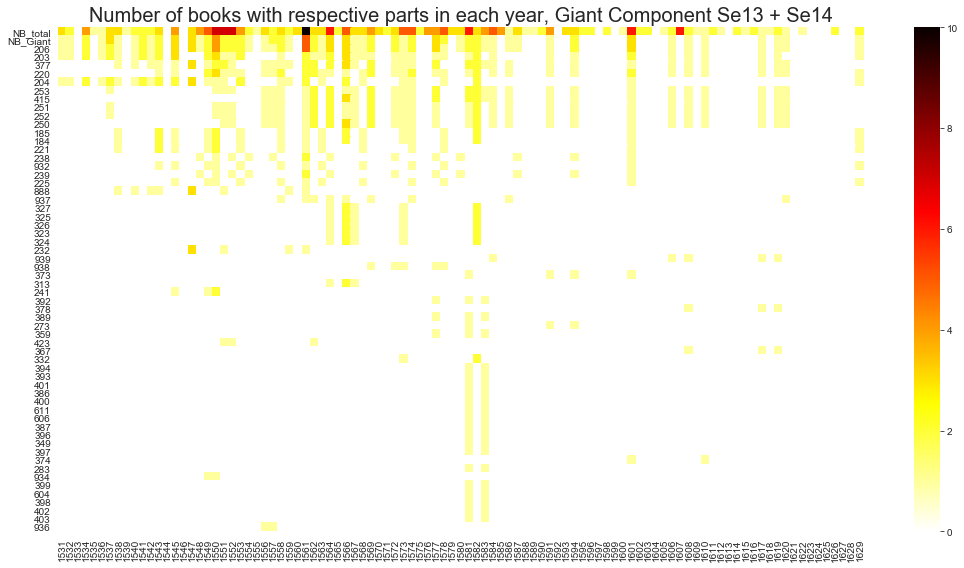

In [14]:
y_tick = ['NB_total','NB_Giant'] + Parts_sorted
plt.figure(figsize=(15,8))
sns.heatmap(Parts_growth_giant, xticklabels=years, yticklabels=y_tick,cmap='hot_r')
plt.title('Number of books with respective parts in each year, Giant Component Se13 + Se14',fontsize=20)
plt.tight_layout()
plt.savefig('Layer_Se13_Se14/Number_of_books_with_parts.pdf')
plt.show() 


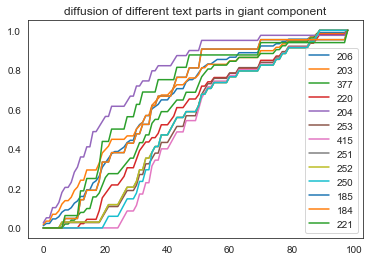

In [15]:
parts_growth_mat = Parts_growth_giant[2:]
Number_of_Parts_in_Giant = parts_growth_mat.shape[0]
Growth_I_parts = {}
for n in range(Number_of_Parts_in_Giant):
    Growth_I_parts[n]=parts_growth_mat[n].cumsum()/sum(parts_growth_mat[n])

plt.plot(Growth_I_parts[0],label=Parts_sorted[0])
plt.plot(Growth_I_parts[1],label=Parts_sorted[1])
plt.plot(Growth_I_parts[2],label=Parts_sorted[2])
plt.plot(Growth_I_parts[3],label=Parts_sorted[3])
plt.plot(Growth_I_parts[4],label=Parts_sorted[4])
plt.plot(Growth_I_parts[5],label=Parts_sorted[5])
plt.plot(Growth_I_parts[6],label=Parts_sorted[6])
plt.plot(Growth_I_parts[7],label=Parts_sorted[7])
plt.plot(Growth_I_parts[8],label=Parts_sorted[8])
plt.plot(Growth_I_parts[9],label=Parts_sorted[9])
plt.plot(Growth_I_parts[10],label=Parts_sorted[10])
plt.plot(Growth_I_parts[11],label=Parts_sorted[11])
plt.plot(Growth_I_parts[12],label=Parts_sorted[12])

plt.legend()
plt.title('diffusion of different text parts in giant component')
plt.show()



In [246]:
# define the true objective function
def objective(x, L, x0, k, b):
           
    return L/(1+np.exp(-k*(x-x0)))+b
 
def find_transmission_rate(It):
    x_g = np.arange(len(It))
    y_g = It    

    p0 = [max(y_g),np.median(x_g),1,min(y_g)]
    # curve fit
    popt, pcov = curve_fit(objective, x_g, y_g,p0,method='dogbox')

    L, x0, k, b = popt
    
    return k


(array([1., 0., 0., 2., 2., 2., 1., 3., 1., 1.]),
 array([0.04102398, 0.04627011, 0.05151623, 0.05676236, 0.06200849,
        0.06725462, 0.07250075, 0.07774688, 0.08299301, 0.08823914,
        0.09348527]),
 <BarContainer object of 10 artists>)

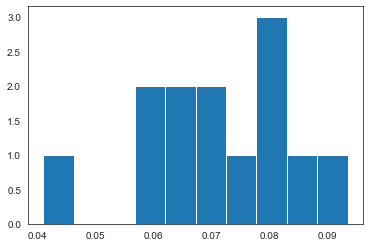

In [252]:
# find the transmission rate of each text parts and plot the histogram of Betas
Betas = []
for n in range(13):
    Betas.append(find_transmission_rate(Growth_I_parts[n]))

plt.hist(Betas,bins=10)    

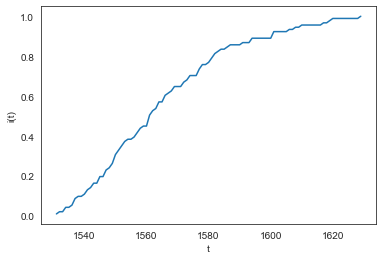

99


In [199]:
years = []
for year in range(Min_Y,Max_Y+1):
    years.append(year)

i_t_giant = Parts_growth_giant[1].cumsum()/len(Books_GiantComp)
S_t_giant=len(Dic_books_year)-Parts_growth_giant[2].cumsum()
S_t_giant=S_t_giant/len(Books_GiantComp)

plt.plot(years,i_t_giant)
plt.ylabel('i(t)')
plt.xlabel('t')
#plt.savefig('it')
plt.show()

print(len(NBooks_Giant))


In [200]:
Part_value = {}
for part in list(set(df_second_comp['Parts'])):
    Part_value[part]=df_second_comp['Parts'].value_counts()[part]


Parts_sorted = sorted(list(set(df_second_comp['Parts'])),key=lambda e:Part_value[e],reverse=True)

List_Year_ID=list(zip(list(df_second_comp['sourceYear']),list(df_second_comp['sourceID'])))+list(zip(list(df_second_comp['targetYear']),list(df_second_comp['targetID'])))
List_Year_ID_total=list(zip(list(df['sourceYear']),list(df['sourceID'])))+list(zip(list(['targetYear']),list(df['targetID'])))

Min_Y_second = min(df_second_comp['sourceYear'])
Max_Y_second = max(df_second_comp['targetYear'])
year_books = {}
year_books_total = {}
for year in range(Min_Y_second,Max_Y_second+1):
    List=[]
    for item in List_Year_ID:
        if item[0]==year:
            List.append(item[1])
    year_books[year]=list(set(List)) 
    
    List2=[]
    for item in List_Year_ID_total:
        if item[0]==year:
            List2.append(item[1])
    year_books_total[year]=list(set(List2))        


NBooks_second = []
NBooks_total = []
for year in range(Min_Y_second,Max_Y_second+1):
    NBooks_second.append(len(year_books[year]))
    NBooks_total.append(len(year_books_total[year]))

    
# For second component
Parts_growth_second = np.zeros((len(Parts_sorted)+1,(Max_Y_second-Min_Y_second+1)))
Parts_growth_second[0] = np.array(NBooks_second)


for part in Parts_sorted:
    i = Parts_sorted.index(part)
    j=0
    for year in range(Min_Y_second,Max_Y_second+1):
        if len(year_books[year])!=0:
            for book in year_books[year]:
                if part in Books_parts[book]:
                    Parts_growth_second[i+1][j]+=1
                    
        j+=1


        
years_second = []
for year in range(Min_Y_second,Max_Y_second+1):
    years_second.append(year)
        
            
    
    

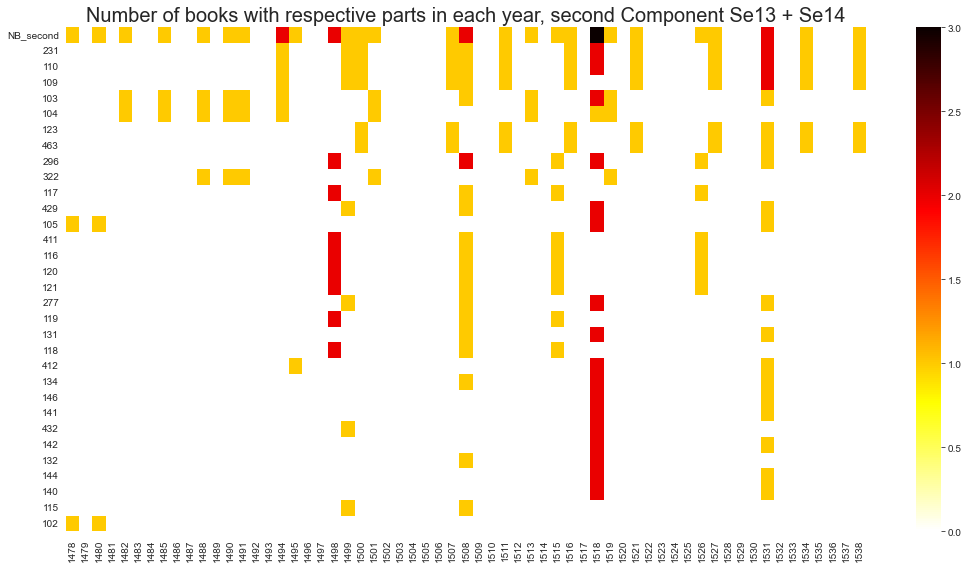

In [201]:
y_tick = ['NB_second'] + Parts_sorted
plt.figure(figsize=(15,8))
sns.heatmap(Parts_growth_second, xticklabels=years_second, yticklabels=y_tick,cmap='hot_r')
plt.title('Number of books with respective parts in each year, second Component Se13 + Se14',fontsize=20)
plt.tight_layout()
plt.savefig('Layer_Se13_Se14/Second_comp_Number_of_books_with_parts')
plt.show() 


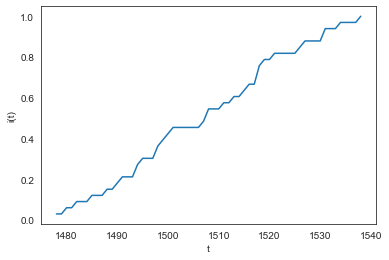

In [202]:
years_second = []
for year in range(Min_Y_second,Max_Y_second+1):
    years_second.append(year)

i_t_second = Parts_growth_second[0].cumsum()/len(Books_SecondComp)
S_t_second=len(Dic_books_year)-Parts_growth_second[0].cumsum()
S_t_second=S_t_second/len(Dic_books_year)

plt.plot(years_second,i_t_second)
plt.ylabel('i(t)')
plt.xlabel('t')
#plt.savefig('it')
plt.show()


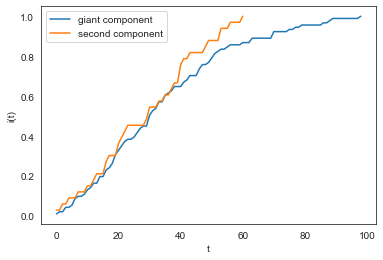

In [203]:
plt.plot(i_t_giant, label = 'giant component')
plt.plot(i_t_second, label='second component')
plt.ylabel('i(t)')
plt.xlabel('t')
plt.legend()
#plt.savefig('it')
plt.show()


In [204]:
Part_value = {}
for part in list(set(df_third_comp['Parts'])):
    Part_value[part]=df_third_comp['Parts'].value_counts()[part]


Parts_sorted = sorted(list(set(df_third_comp['Parts'])),key=lambda e:Part_value[e],reverse=True)

List_Year_ID=list(zip(list(df_third_comp['sourceYear']),list(df_third_comp['sourceID'])))+list(zip(list(df_third_comp['targetYear']),list(df_third_comp['targetID'])))
List_Year_ID_total=list(zip(list(df['sourceYear']),list(df['sourceID'])))+list(zip(list(['targetYear']),list(df['targetID'])))

Min_Y_third = min(df_third_comp['sourceYear'])
Max_Y_third = max(df_third_comp['targetYear'])
year_books = {}
year_books_total = {}
for year in range(Min_Y_third,Max_Y_third+1):
    List=[]
    for item in List_Year_ID:
        if item[0]==year:
            List.append(item[1])
    year_books[year]=list(set(List)) 
    
    List2=[]
    for item in List_Year_ID_total:
        if item[0]==year:
            List2.append(item[1])
    year_books_total[year]=list(set(List2))        


NBooks_third = []
NBooks_total = []
for year in range(Min_Y_third,Max_Y_third+1):
    NBooks_third.append(len(year_books[year]))
    NBooks_total.append(len(year_books_total[year]))

    
# For third component
Parts_growth_third = np.zeros((len(Parts_sorted)+1,(Max_Y_third-Min_Y_third+1)))
Parts_growth_third[0] = np.array(NBooks_third)


for part in Parts_sorted:
    i = Parts_sorted.index(part)
    j=0
    for year in range(Min_Y_third,Max_Y_third+1):
        if len(year_books[year])!=0:
            for book in year_books[year]:
                if part in Books_parts[book]:
                    Parts_growth_third[i+1][j]+=1
                    
        j+=1


        
years_third = []
for year in range(Min_Y_third,Max_Y_third+1):
    years_third.append(year)
        
                

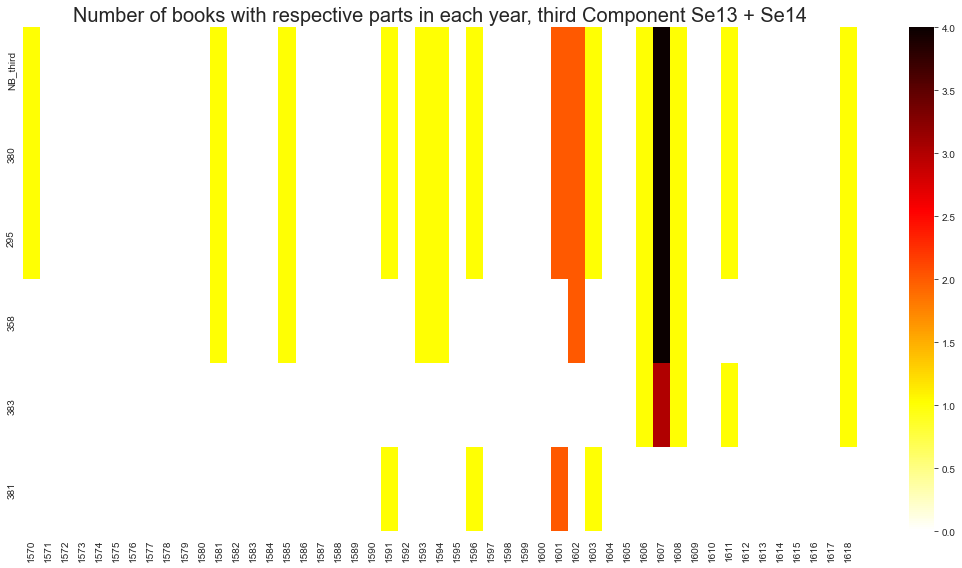

In [205]:
y_tick = ['NB_third'] + Parts_sorted
plt.figure(figsize=(15,8))
sns.heatmap(Parts_growth_third, xticklabels=years_third, yticklabels=y_tick,cmap='hot_r')
plt.title('Number of books with respective parts in each year, third Component Se13 + Se14',fontsize=20)
plt.tight_layout()
plt.savefig('Layer_Se13_Se14/third_comp_Number_of_books_with_parts')
plt.show() 


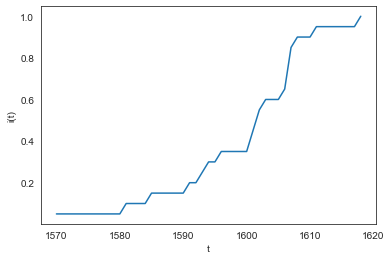

In [206]:
years_third = []
for year in range(Min_Y_third,Max_Y_third+1):
    years_third.append(year)

i_t_third = Parts_growth_third[0].cumsum()/len(Books_ThirdComp)
S_t_third=len(Dic_books_year)-Parts_growth_third[0].cumsum()
S_t_third=S_t_third/len(Dic_books_year)

plt.plot(years_third,i_t_third)
plt.ylabel('i(t)')
plt.xlabel('t')
#plt.savefig('it')
plt.show()


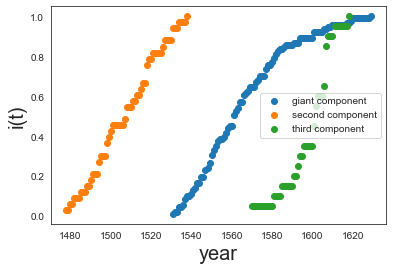

In [207]:
plt.scatter(years,i_t_giant, label = 'giant component')
plt.scatter(years_second,i_t_second, label='second component')
plt.scatter(years_third,i_t_third, label='third component')
plt.ylabel('i(t)',size=20)
plt.xlabel('year',size=20)
plt.legend()
plt.savefig('it_three_components')
plt.show()


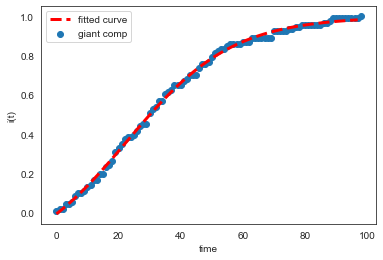

[ 1.26587052 22.73721101  0.05884601 -0.26848228]


In [208]:

 
# define the true objective function
def objective(x, L, x0, k, b):
           
    return L/(1+np.exp(-k*(x-x0)))+b
 

x_g = np.arange(len(i_t_giant))
y_g = i_t_giant    

p0 = [max(y_g),np.median(x_g),1,min(y_g)]
# curve fit
popt, pcov = curve_fit(objective, x_g, y_g,p0,method='dogbox')


popt

# summarize the parameter values
L, x0, k, b = popt

# plot input vs output
plt.scatter(x_g, y_g, label='giant comp')
# define a sequence of inputs between the smallest and largest known inputs
x_line_g = arange(min(x_g), max(x_g), 1)
# calculate the output for the range
y_line_g = objective(x_line_g, L, x0, k, b)
# create a line plot for the mapping function
plt.plot(x_line_g, y_line_g, '--', color='red', linewidth=3,label='fitted curve')
plt.xlabel('time')
plt.ylabel('i(t)')
plt.legend()
plt.savefig('i_t_giant_comp_fit')
plt.show()

print(popt)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


i0 0.01098901098901099
a--g 0.012250646567647572
b--g 0.044744226270158026


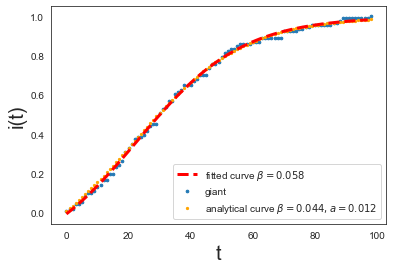

In [209]:
from scipy.optimize import fsolve
import math

i0=i_t_giant[0]
print('i0',i0)
t1=x_g[20]
It1=y_g[20]

t2=x_g[70]
It2=y_g[70]

def equations(p):
    a, b = p
    return ((It1-1)*(i0*b+a)*math.exp(t1*(a+b))-((i0-1)*(b*It1+a)),(It2-1)*(i0*b+a)*math.exp(t2*(a+b))-((i0-1)*(b*It2+a)))

a, b =  fsolve(equations, (0.058, 0.0006))


Fit_g = []
for t in x_g:
    h=((b*i0+a)*math.exp(t*(a+b))+a*(i0-1))/((b*i0+a)*math.exp(t*(a+b))-b*(i0-1))
    Fit_g.append(h)
    

plt.scatter(x_g, y_g,s=7, label='giant')
plt.plot(x_line_g, y_line_g, '--', color='red', linewidth=3,label=r'fitted curve $\beta=0.058$')
plt.scatter(x_g,Fit_g,marker='o',s=5,c='orange',label=r'analytical curve $\beta=0.044, a=0.012$')   # This is with Betha = 0.0626
plt.ylabel('i(t)',size=20)  
plt.xlabel('t',size=20)
plt.legend()
plt.savefig('It_GComp_Analytic.eps')
print('a--g',a)
print('b--g',b)



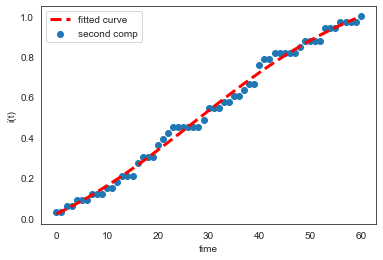

[ 1.46819768 27.4328165   0.0536801  -0.25163641]


In [210]:
 
# define the true objective function
def objective(x, L, x0, k, b):
           
    return L/(1+np.exp(-k*(x-x0)))+b
 

x_s = np.arange(len(i_t_second))
y_s = i_t_second    

p0 = [max(y_s),np.median(x_s),1,min(y_s)]
# curve fit
popt, pcov = curve_fit(objective, x_s, y_s,p0,method='dogbox')


popt

# summarize the parameter values
L, x0, k, b = popt

# plot input vs output
plt.scatter(x_s, y_s, label='second comp')
# define a sequence of inputs between the smallest and largest known inputs
x_line_s = arange(min(x_s), max(x_s), 1)
# calculate the output for the range
y_line_s = objective(x_line_s, L, x0, k, b)
# create a line plot for the mapping function
plt.plot(x_line_s, y_line_s, '--', color='red', linewidth=3,label='fitted curve')
plt.xlabel('time')
plt.ylabel('i(t)')
plt.legend()
plt.savefig('i_t_second_comp_fit')
plt.show()

print(popt)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


i0 0.030303030303030304


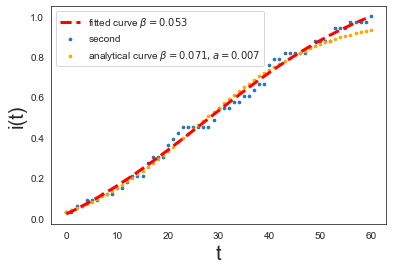

a--g 0.007231777444487088
b--g 0.07142801542136605


In [211]:
i0=i_t_second[0]
print('i0',i0)
t1=x_s[10]
It1=y_s[10]

t2=x_s[46]
It2=y_s[46]

def equations(p):
    a, b = p
    return ((It1-1)*(i0*b+a)*math.exp(t1*(a+b))-((i0-1)*(b*It1+a)),(It2-1)*(i0*b+a)*math.exp(t2*(a+b))-((i0-1)*(b*It2+a)))

a, b =  fsolve(equations, (0.007,0.056))


Fit_s = []
for t in x_s:
    h=((b*i0+a)*math.exp(t*(a+b))+a*(i0-1))/((b*i0+a)*math.exp(t*(a+b))-b*(i0-1))
    Fit_s.append(h)
    

plt.scatter(x_s, y_s,s=7, label='second')
plt.plot(x_line_s, y_line_s, '--', color='red', linewidth=3,label=r'fitted curve $\beta=0.053$')
plt.scatter(x_s,Fit_s,marker='o',s=7,c='orange',label=r'analytical curve $\beta=0.071, a=0.007$')   # This is with Betha = 0.0626
plt.ylabel('i(t)',size=20)  
plt.xlabel('t',size=20)
plt.legend()
plt.savefig('It_SecComp_Analytic.eps')
plt.show()
print('a--g',a)
print('b--g',b)


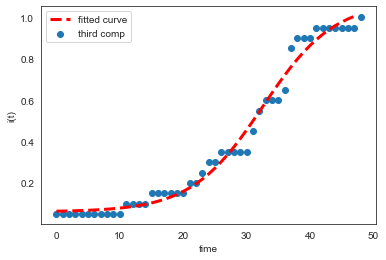

[ 1.01822807 32.54316502  0.17778196  0.06005165]


In [212]:
 
# define the true objective function
def objective(x, L, x0, k, b):
           
    return L/(1+np.exp(-k*(x-x0)))+b
 

x_t = np.arange(len(i_t_third))
y_t = i_t_third    

p0 = [max(y_t),np.median(x_t),1,min(y_t)]
# curve fit
popt, pcov = curve_fit(objective, x_t, y_t,p0,method='dogbox')


popt

# summarize the parameter values
L, x0, k, b = popt

# plot input vs output
plt.scatter(x_t, y_t, label='third comp')
# define a sequence of inputs between the smallest and largest known inputs
x_line_t = arange(min(x_t), max(x_t), 1)
# calculate the output for the range
y_line_t = objective(x_line_t, L, x0, k, b)
# create a line plot for the mapping function
plt.plot(x_line_t, y_line_t, '--', color='red', linewidth=3,label='fitted curve')
plt.xlabel('time')
plt.ylabel('i(t)')
plt.legend()
plt.savefig('i_t_third_comp_fit')
plt.show()

print(popt)


i0 0.05


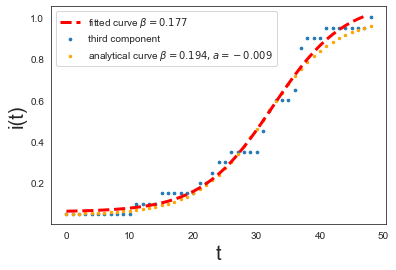

a--g -0.009180543410588222
b--g 0.19457940870829016


In [213]:
i0=i_t_third[0]
print('i0',i0)
t1=x_t[20]
It1=y_t[20]

t2=x_t[47]
It2=y_t[47]

def equations(p):
    a, b = p
    return ((It1-1)*(i0*b+a)*math.exp(t1*(a+b))-((i0-1)*(b*It1+a)),(It2-1)*(i0*b+a)*math.exp(t2*(a+b))-((i0-1)*(b*It2+a)))

a, b =  fsolve(equations, (0.17, 0.11))


Fit_t = []
for t in x_t:
    h=((b*i0+a)*math.exp(t*(a+b))+a*(i0-1))/((b*i0+a)*math.exp(t*(a+b))-b*(i0-1))
    Fit_t.append(h)
    

plt.scatter(x_t, y_t,s=7, label='third component')
plt.plot(x_line_t, y_line_t, '--', color='red', linewidth=3,label=r'fitted curve $\beta=0.177$')
plt.scatter(x_t,Fit_t,marker='o',s=6,c='orange',label=r'analytical curve $\beta=0.194, a=-0.009$')   # This is with Betha = 0.0626
plt.ylabel('i(t)',size=20)  
plt.xlabel('t',size=20)
plt.legend()
plt.savefig('It_ThirdComp_Analytic.pdf')
plt.show()
print('a--g',a)
print('b--g',b)


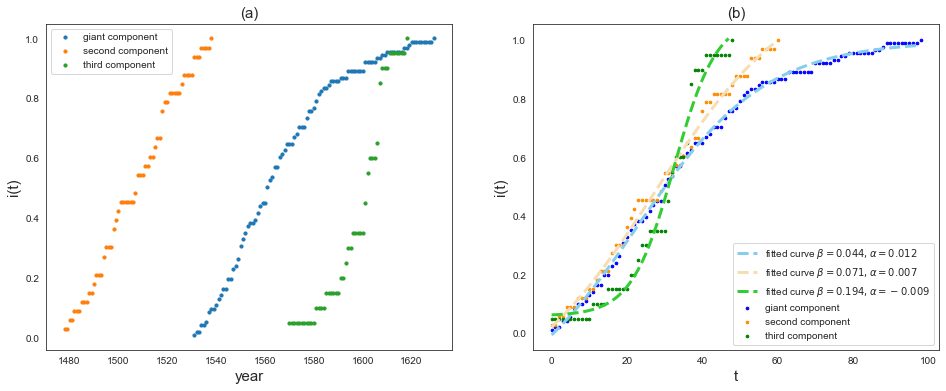

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(years,i_t_giant,s=10,label = 'giant component')
axes[0].scatter(years_second,i_t_second,s=10, label='second component')
axes[0].scatter(years_third,i_t_third,s=10, label='third component')
# This is with Betha = 0.0626
axes[0].legend()
axes[0].set_title('(a)',size=15)
axes[0].set_ylabel('i(t)',size=15)
axes[0].set_xlabel('year',size=15)


axes[1].scatter(x_g, y_g,s=7, color='blue', label='giant component')
axes[1].plot(x_line_g, y_line_g, '--', color='skyblue', linewidth=3,label=r'fitted curve $\beta=0.044, \alpha=0.012$')

axes[1].scatter(x_s, y_s,s=7, color='darkorange', label='second component')
axes[1].plot(x_line_s, y_line_s, '--', color='wheat', linewidth=3,label=r'fitted curve $\beta=0.071, \alpha=0.007$')

axes[1].scatter(x_t, y_t,s=7, color='green', label='third component')
axes[1].plot(x_line_t, y_line_t, '--', color='limegreen', linewidth=3,label=r'fitted curve $\beta=0.194, \alpha=-0.009$')

axes[1].legend()
axes[1].set_title('(b)',size=15)
axes[1].set_ylabel('i(t)',size=15)
axes[1].set_xlabel('t',size=15)

plt.savefig('It_Diff_Component_1.pdf')
plt.show()
